<a href="https://colab.research.google.com/github/Shaielyfs/analise_geoespacial/blob/main/operacoes_matematicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#instalar as bibliotecas necessarias

!pip install rasterio -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 34.3 MB/s eta 0:00:00


In [2]:
#importar bibliotecas
import geopandas as gpd
import pandas as pd
import zipfile
import requests
import json
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt

import rasterio
from rasterio.transform import from_origin
from rasterio.mask import mask
from rasterio.features import shapes, rasterize
from rasterio.warp import calculate_default_transform, reproject, Resampling

from scipy.ndimage import rotate
from scipy.spatial import distance_matrix
from scipy.ndimage import gaussian_filter

In [3]:
#descompactando o arquivo topodata
with zipfile.ZipFile('/content/drive/MyDrive/analise_geoespacial_part2/07S36_ZN.zip') as zip_ref:
  zip_ref.extractall('/07S36_ZN')
#descompactando o arqivo municipios
with zipfile.ZipFile('/content/drive/MyDrive/analise_geoespacial_part2/PB_Municipios_2022.zip', 'r') as zip_ref:
  zip_ref.extractall('PB_Municipios')

In [5]:
#ler dados shape
municipios = gpd.read_file('/content/PB_Municipios/PB_Municipios_2022.shp')
municipio_especifico = municipios[municipios['NM_MUN'] == 'João Pessoa']

In [8]:
#carregar o raster recortado
with rasterio.open('/07S36_ZN/07S36_ZN.tif') as src:
  #abrir uma imagem rasterio
  out_image, out_transform = mask(src, municipio_especifico.geometry, crop=True)

  #remove a primeira dimensao se ela tem tamanho 1
  out_image = out_image.squeeze()

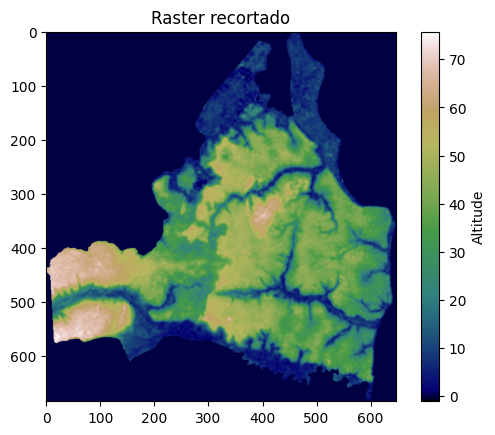

In [9]:
#vizualizar a imagem
plt.imshow(out_image, cmap='gist_earth')
plt.colorbar(label='Altitude')
plt.title('Raster recortado')
plt.show()

In [10]:
#redimensionar a imagem recortada
altura_nova, largura_nova = 40, 40

#redimensionamento da imagem
reclassified_resized = resize(out_image, (altura_nova, largura_nova), preserve_range=True)

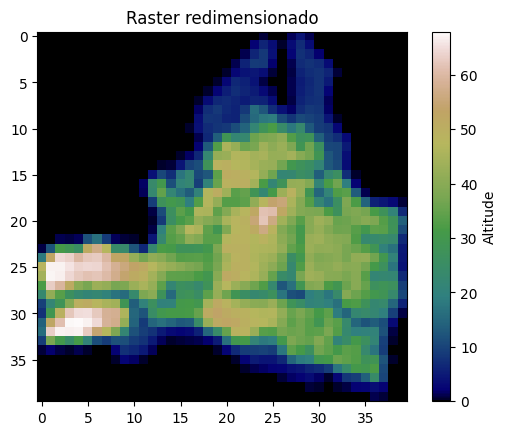

In [11]:
plt.imshow(reclassified_resized, cmap='gist_earth')
plt.colorbar(label='Altitude')
plt.title("Raster redimensionado")
plt.show()

In [21]:
#definir sistema de referencia
dest_crs = 'EPSG:4326'  #WGS 84

In [33]:
#abrir raster original
with rasterio.open('/07S36_ZN/07S36_ZN.tif') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dest_crs, src.width, src.height, *src.bounds)

  #parametros do novo dataset , dicionario
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dest_crs,
      'transform' : transform,
      'width': width,
      'height': height
  })

  #criar e salvar o raster reprojetado
  with rasterio.open('/07S36_ZN/raster_reprojetado.tif', 'w', **kwargs) as dst:
    for i in range(1, src.count + 1):
      reproject(
          source=rasterio.band(src, i),
          destination=rasterio.band(dst, i),
          src_transform=src.transform,
          src_crs=src.crs,
          dst_transform=transform,
          dst_crs=dest_crs,
          resampling=Resampling.nearest
      )

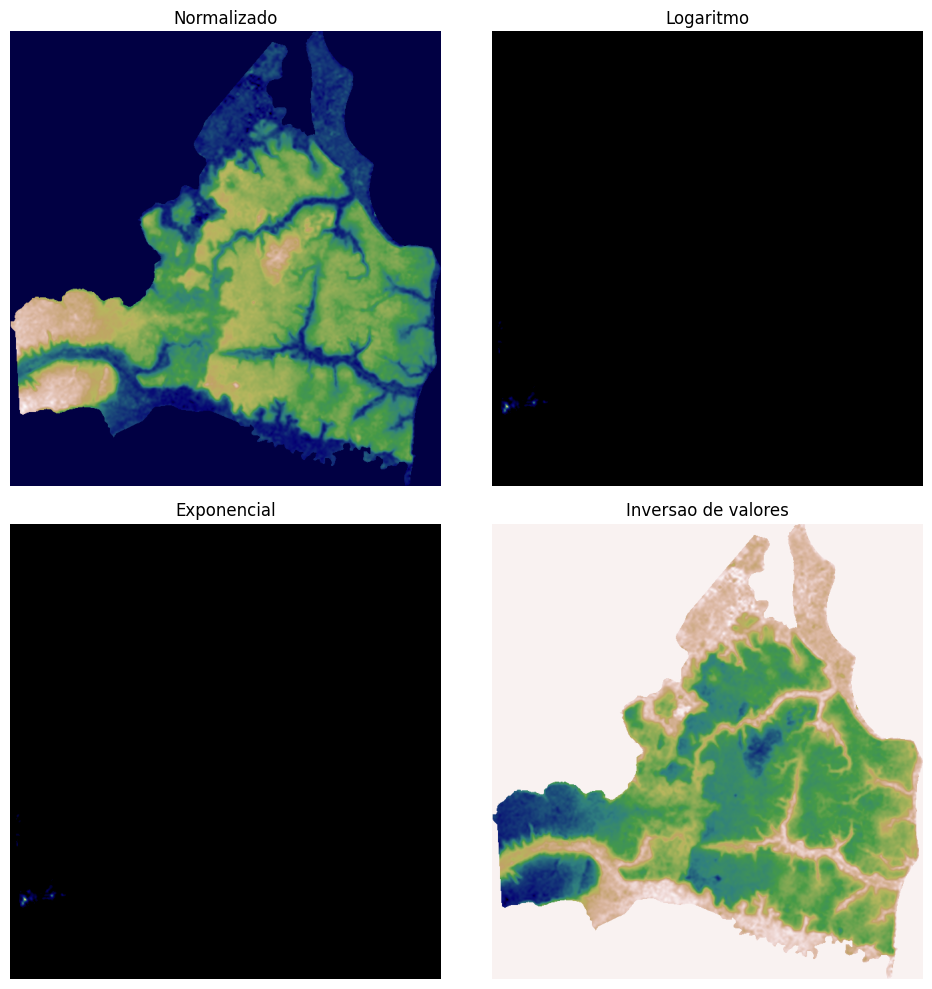

In [38]:
#Normalizacao
normalized = (out_image - out_image.min()) / (out_image.max() - out_image.min() )

#Logaritmo
log_transformed = np.exp(out_image)

#Exponencial
exponenntial_transform = np.exp(out_image)

#Inversao de valore
inverted = np.max(out_image) - out_image

#Visualizacao
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(normalized, cmap='gist_earth')
axs[0, 0].set_title('Normalizado')
axs[0, 1].imshow(log_transformed, cmap='gist_earth')
axs[0, 1].set_title('Logaritmo')
axs[1, 0].imshow(exponenntial_transform, cmap='gist_earth')
axs[1, 0].set_title('Exponencial')
axs[1, 1].imshow(inverted, cmap='gist_earth')
axs[1, 1].set_title('Inversao de valores')

for ax in axs.flat:
    ax.axis('off')
plt.tight_layout()
plt.show()